# Using shapefiles to calculate zonal statistics

In [9]:
#This first line will show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
import pandas as pd
from dask.distributed import Client, progress
import cmocean as cm                              # Nice colormaps
import cartopy.crs as ccrs                        # For making maps with different projections
import cartopy.feature as cft                     # For adding features to maps
import copy

#Libraries used in zonal statistics calculations
from rasterstats import zonal_stats
import rasterio
import geopandas
import rasterio.plot
import rioxarray
from shapely.geometry import mapping, Polygon

In [10]:
client = Client(n_workers = 12)

In [11]:
session = cc.database.create_session()

## Accessing ACCESS-OM2-01 model outputs
This script uses cycle 2 model outputs to calculate variable means using a shapefile

In [12]:
#Set up variables
#Experiment
exp = "01deg_jra55v140_iaf_cycle2"

#Variable of interest
varInt = 'surface_temp' #SST

In [5]:
#Querying experiment variables
expvar = cc.querying.get_variables(session, exp)
# expvar
#Extract variables with keywords included in its long_name column
expvar[expvar["name"].str.lower().str.match(".*area.*")] #force all letters to be lowercase to get matches

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
71,tarea,area of T grid cells,1 daily,output487/ice/OUTPUT/iceh.2018-12-daily.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00
100,uarea,area of U grid cells,1 daily,output487/ice/OUTPUT/iceh.2018-12-daily.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00
225,tarea,area of T grid cells,1 monthly,output487/ice/OUTPUT/iceh.2018-12.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00
245,uarea,area of U grid cells,1 monthly,output487/ice/OUTPUT/iceh.2018-12.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00
260,area_t,tracer cell area,static,output422/ocean/ocean-2d-area_t.nc,244,1900-01-01 00:00:00,1900-01-01 00:00:00
261,area_u,velocity cell area,static,output404/ocean/ocean-2d-area_u.nc,244,1900-01-01 00:00:00,1900-01-01 00:00:00


In [13]:
#Give the start and end dates for the analyses. The input must be given as a list, even if it is one item only.
#Dates can be given as full date (e.g., 2010-01-01), just year and month, or just year. If multiple years are to be analysed, ensure both variables have the same length
#Start date
stime = [str(i)+'-01-10' for i in range(1965, 2019, 1)]
#End date
etime = [str(i)+'-12-20' for i in range(1965, 2019, 1)]
#Define frequency. Remember to check frequency and variable of interest are related to each other, for example, aice_m has a monthly frequency, while aice has a daily frequency.
freq = '1 monthly'

**Defining function accessing and slicing ACCESS-OM2-01 outputs**
Defining function that loads data automatically using `cc.querying.getvar()` in a loop. The inputs needed are similar to those for the `cc.querying.getvar()` function, with the addition of inputs to define an area of interest.

The `getACCESSdata` function will achieve the following:
- Access data for the experiment and variable of interest at the frequency requested and within the time frame specified
- Apply time corrections as midnight (00:00:00) is interpreted differently by the CICE model and the xarray package.
    - CICE reads 2010-01-01 00:00:00 as the start of 2010-01-01, while xarray interprets it as the start of the following day (2010-01-02). To fix this problem, 12 hours are subtracted from the time dimension (also known as time coordinate).
- Latitude and longitude will be corrected in the dataset using the geolon_t dataset. The coordinate names are replaced by names that are more intuitive.
- Minimum and maximum latitudes and longitudes can be specified in the function to access specific areas of the dataset if required. By default, the longitudes are set to show the Southern Ocean, which is defined as ocean waters south of 45S.

In [14]:
#Frequency, experiment and session do not need to be specified if they were defined in the previous step
def getACCESSdata(var, start, end, minlat = -90, maxlat = -45, exp = exp, freq = freq, ses = session):
    '''
    Inputs:
    var - Short name for the variable of interest
    start - Time from when data has to be returned
    end - Time until when data has to be returned
    minlat - minimum latitude from which to return data. If not set, defaults to -90 to cover the Southern Ocean.
    maxlat - maximum latitude from which to return data. If not set, defaults to -45 to cover the Southern Ocean.
    exp - Experiment name
    freq - Time frequency of the data
    ses - Cookbook session
        
    Output:
    Data array with corrected time and coordinates within the specified time period and spatial bounding box.
    '''
    #Accessing data
    vararray = cc.querying.getvar(exp, var, ses, frequency = freq, start_time = start, end_time = end)
    #Subsetting data to area of interest
    vararray = vararray.sel(yt_ocean = slice(minlat, maxlat))
    #Transform temperature from Kelvin to Celsius
    vararray = vararray-273.15
    return vararray

### Loading data
**Accessing variable of interest**

In [15]:
SO_SST = getACCESSdata(varInt, stime[0], etime[-1], exp = exp, freq = freq, ses = session)
SO_SST

<xarray.DataArray 'surface_temp' (time: 648, yt_ocean: 740, xt_ocean: 3600)>
dask.array<sub, shape=(648, 740, 3600), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
  * time      (time) object 1965-01-16 12:00:00 ... 2018-12-16 12:00:00

**Accessing area per pixel to calculate weights**

In [16]:
#Loading ocean area to create weights
area =  cc.querying.getvar(exp, 'area_t', session, frequency = 'static', n = -1)
area = area.sel(yt_ocean = slice(-90, -45))
area

<xarray.DataArray 'area_t' (yt_ocean: 740, xt_ocean: 3600)>
dask.array<getitem, shape=(740, 3600), dtype=float32, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t

## Correcting longitude values in ACCESS-OM2-01 model outputs
Model outputs for ACCESS-OM2-01 range from -280 to +80, which causes problems with trying to perform spatial analyses on this data. To avoid issues, longitude values need to be corrected so they range between -180 and +180. This correction require several steps as there is no way to perform a simple conversion using `xr.assign_coords` or `xr.where`.  
  
The `corrlong` function defined below will perform this corrections easily. The only input required is the dataset that needs longitude correction. It will return a the same data array with longitude values ranging from -180 to +180.

In [17]:
def corrlong(array):
    '''
    Inputs:
    array - Data array on which longitude corrections will be applied.
    
    Output:
    Data array with corrected longitude values.
    '''
    
    #Making a deep copy of original longitude values in the array being corrected
    corr_lon = copy.deepcopy(array.xt_ocean.values)
    
    ##Now we need to correct any values smaller than -180 and replace them with values between +80 and +180. Note that the smallest longitude value (-279.95) should be +80.05.
    #While -180.05 should have a correct value of +179.95.
    corr_lon[np.where(corr_lon < -180)] = sorted(-corr_lon[np.where((corr_lon >= -180) & (corr_lon <= -80))])
    
    #Assign corrected longitude values to the data array being corrected
    array.coords['xt_ocean'] = corr_lon
    
    #Longitude values must be sorted from smallest to largest prior to plotting
    array = array.sortby(array.xt_ocean)
    
    return array

In [20]:
#Correcting data arraty containing variable of interest and area per pixel
SO_SSTc = corrlong(SO_SST)
area_c = corrlong(area)

# Calculating zonal statistics on a data array using a shapefile

**Loading the shapefile**  
The shapefile being used must have decimal degrees as units, so it matches ACCESS-OM2-01 outputs. Any shapefile can be used to calculate zonal statistics.  
If the shapefiles contain multiple areas of interest, these areas need to be included under a column called `SectorName` to perform calculations within each sector.

In [18]:
#Access shapefile containing the boundaries being used to calculate zonal statistics - Include the entire file path to the shapefile
regions = geopandas.read_file(r'/g/data/v45/la6889/GIS_DataBase/Shapefiles/ACE_ecostasts/aes_polar_regions_simple_wgs84.shp')
regions

,SectorName,Zone,area_km2,colour,geometry
0,Indian,Polar,1.240618e+07,#00BFC499,"POLYGON ((145.00000 -65.93236, 145.00000 -67.0..."
1,WestPacific,Polar,9.022348e+06,#F8766DFF,"MULTIPOLYGON (((-180.00000 -71.57423, -180.000..."
2,EastPacific,Polar,3.966731e+06,#C77CFFFF,"POLYGON ((-58.36516 -61.47690, -58.30158 -61.5..."
3,Atlantic,Polar,2.094065e+07,#7CAE00FF,"POLYGON ((-57.00803 -63.29530, -56.96140 -63.2..."


<AxesSubplot:title={'center':'time = 1965-01-16 12:00:00'}, xlabel='xt_ocean', ylabel='tcell latitude [degrees_N]'>

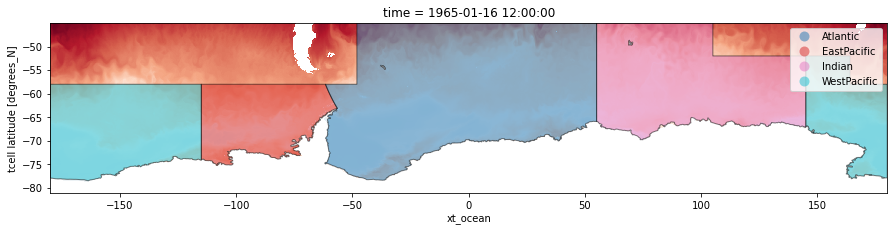

In [21]:
#Plot shapefile over the raster to ensure they both have the same CRS and cover the same area
#Initialise figure
fig, ax = plt.subplots(figsize = (15, 15))
#Plot just one timestep of the data array
SO_SSTc[0].plot(ax = ax, add_colorbar = False)
#Plot shapefile over the top and show each sector in different colour
regions.plot(ax = ax, column = 'SectorName', legend = True, alpha = 0.5, edgecolor = 'black')

**Clipping data arrays**

The `clipDataArray` function assigns the same coordinate reference system (CRS) to the data array as the clipping shapefile prior to clipping the array. This function needs two inputs:
- array - Data array to be clipped.
- shp - Shapefile to be used for clipping.  
  
The function will return the a clipped data array.

In [13]:
def clipDataArray(array, shp):
    '''
    Inputs:
    array - Data array to be clipped.
    shp - Shapefile to be used for clipping.
    
    Output:
    Clipped data array.
    '''
    crs = 'epsg:' + str(regions.crs.to_epsg())
    array.rio.set_spatial_dims(x_dim = 'xt_ocean', y_dim = 'yt_ocean', inplace = True)
    array.rio.write_crs(crs, inplace = True)
    
    clipped = array.rio.clip(shp.geometry.apply(mapping), shp.crs, drop = True, invert = False)
    
    return clipped

Note that if a shapefile includes multiple regions of interest, the resulting clipped area will cover the entire shapefile. It will not clip the data array per region in the shapefile. If the data array needs to be clipped per region, that specific region needs to be selected.

In [14]:
#Clipping data arrays
Indian = clipDataArray(SO_SSTc, shp = regions.query('SectorName == "{}"'.format(regions.SectorName.values[0])))
Indian_a = clipDataArray(area_c, shp = regions.query('SectorName == "Indian"'))

WestPacific = clipDataArray(SO_SSTc, shp = regions.query('SectorName == "{}"'.format(regions.SectorName.values[1])))
WP_a = clipDataArray(area_c, shp = regions.query('SectorName == "{}"'.format(regions.SectorName.values[1])))

EastPacific = clipDataArray(SO_SSTc, shp = regions.query('SectorName == "{}"'.format(regions.SectorName.values[2])))
EP_a = clipDataArray(area_c, shp = regions.query('SectorName == "{}"'.format(regions.SectorName.values[2])))

Atlantic = clipDataArray(SO_SSTc, shp = regions.query('SectorName == "{}"'.format(regions.SectorName.values[3])))
Atlantic_a = clipDataArray(area_c, shp = regions.query('SectorName == "{}"'.format(regions.SectorName.values[3])))

## Calculating weighted means by area

The `weightedMeans` function calculates the weighted means. This function needs two inputs:
- array - Data array containing the data on which weighted means will be calculated.
- weights - Data array containing weights data.  
  
The function will return the a data array containing the weighted mean calculated per timestep.

In [15]:
def weightedMeans(array, weights):
    '''
    Inputs:
    array - Data array containing variable from which means will be calculated
    weights - Data array containing weights
    
    Output:
    Data array containing weighted means
    '''
    
    #Calculate weights
    weights.name = 'weights'
    weights = weights.fillna(0)
    
    #Apply weights to variable
    weighted_var = array.weighted(weights)
    
    #Calculate weighted mean per timestep
    weighted_mean = weighted_var.mean(("xt_ocean", "yt_ocean"))
    
    return weighted_mean

In [59]:
#Calculating weighted means per sector
weightedIndian = weightedMeans(Indian, Indian_a)
weightedWP = weightedMeans(WestPacific, WP_a)
weightedEP = weightedMeans(EastPacific, EP_a)
weightedAtlantic = weightedMeans(Atlantic, Atlantic_a)

## Plotting results

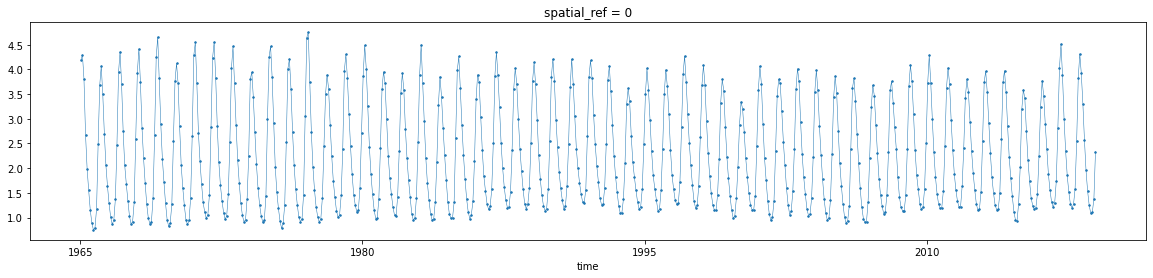

In [60]:
weightedIndian.plot(figsize = (20, 4), linewidth=0.5, marker='o',markersize=1.5)

In [61]:
# weightedIndian.resample(time = '10Y').mean().plot()
weightedIndian.time.dt.strftime("%b %Y")

<xarray.DataArray 'strftime' (time: 648)>
array(['Jan 1965', 'Feb 1965', 'Mar 1965', 'Apr 1965', 'May 1965',
       'Jun 1965', 'Jul 1965', 'Aug 1965', 'Sep 1965', 'Oct 1965',
       'Nov 1965', 'Dec 1965', 'Jan 1966', 'Feb 1966', 'Mar 1966',
       'Apr 1966', 'May 1966', 'Jun 1966', 'Jul 1966', 'Aug 1966',
       'Sep 1966', 'Oct 1966', 'Nov 1966', 'Dec 1966', 'Jan 1967',
       'Feb 1967', 'Mar 1967', 'Apr 1967', 'May 1967', 'Jun 1967',
       'Jul 1967', 'Aug 1967', 'Sep 1967', 'Oct 1967', 'Nov 1967',
       'Dec 1967', 'Jan 1968', 'Feb 1968', 'Mar 1968', 'Apr 1968',
       'May 1968', 'Jun 1968', 'Jul 1968', 'Aug 1968', 'Sep 1968',
       'Oct 1968', 'Nov 1968', 'Dec 1968', 'Jan 1969', 'Feb 1969',
       'Mar 1969', 'Apr 1969', 'May 1969', 'Jun 1969', 'Jul 1969',
       'Aug 1969', 'Sep 1969', 'Oct 1969', 'Nov 1969', 'Dec 1969',
       'Jan 1970', 'Feb 1970', 'Mar 1970', 'Apr 1970', 'May 1970',
       'Jun 1970', 'Jul 1970', 'Aug 1970', 'Sep 1970', 'Oct 1970',
       'Nov 1970', 'Dec 1970', 'Jan 1971', 'Feb 1971', 'Mar 1971',
       'Apr 1971', 'May 1971', 'Jun 1971', 'Jul 1971', 'Aug 1971',
       'Sep 1971', 'Oct 1971', 'Nov 1971', 'Dec 1971', 'Jan 1972',
       'Feb 1972', 'Mar 1972', 'Apr 1972', 'May 1972', 'Jun 1972',
       'Jul 1972', 'Aug 1972', 'Sep 1972', 'Oct 1972', 'Nov 1972',
       'Dec 1972', 'Jan 1973', 'Feb 1973', 'Mar 1973', 'Apr 1973',
...
       'Nov 2010', 'Dec 2010', 'Jan 2011', 'Feb 2011', 'Mar 2011',
       'Apr 2011', 'May 2011', 'Jun 2011', 'Jul 2011', 'Aug 2011',
       'Sep 2011', 'Oct 2011', 'Nov 2011', 'Dec 2011', 'Jan 2012',
       'Feb 2012', 'Mar 2012', 'Apr 2012', 'May 2012', 'Jun 2012',
       'Jul 2012', 'Aug 2012', 'Sep 2012', 'Oct 2012', 'Nov 2012',
       'Dec 2012', 'Jan 2013', 'Feb 2013', 'Mar 2013', 'Apr 2013',
       'May 2013', 'Jun 2013', 'Jul 2013', 'Aug 2013', 'Sep 2013',
       'Oct 2013', 'Nov 2013', 'Dec 2013', 'Jan 2014', 'Feb 2014',
       'Mar 2014', 'Apr 2014', 'May 2014', 'Jun 2014', 'Jul 2014',
       'Aug 2014', 'Sep 2014', 'Oct 2014', 'Nov 2014', 'Dec 2014',
       'Jan 2015', 'Feb 2015', 'Mar 2015', 'Apr 2015', 'May 2015',
       'Jun 2015', 'Jul 2015', 'Aug 2015', 'Sep 2015', 'Oct 2015',
       'Nov 2015', 'Dec 2015', 'Jan 2016', 'Feb 2016', 'Mar 2016',
       'Apr 2016', 'May 2016', 'Jun 2016', 'Jul 2016', 'Aug 2016',
       'Sep 2016', 'Oct 2016', 'Nov 2016', 'Dec 2016', 'Jan 2017',
       'Feb 2017', 'Mar 2017', 'Apr 2017', 'May 2017', 'Jun 2017',
       'Jul 2017', 'Aug 2017', 'Sep 2017', 'Oct 2017', 'Nov 2017',
       'Dec 2017', 'Jan 2018', 'Feb 2018', 'Mar 2018', 'Apr 2018',
       'May 2018', 'Jun 2018', 'Jul 2018', 'Aug 2018', 'Sep 2018',
       'Oct 2018', 'Nov 2018', 'Dec 2018'], dtype=object)
Coordinates:
  * time         (time) object 1965-01-16 12:00:00 ... 2018-12-16 12:00:00
    spatial_ref  int64 0

In [ ]:
## Get list of years included in data array
# chunk_ids = np.unique(weightedIndian.indexes['time'].to_datetimeindex().year.values)
# chunk_ids

# np.repeat()
# np.arange(1,10)
# chunk = np.repeat(np.arange(1, np.ceil(732/120)+1), 120)
# chunk = chunk[:-abs(len(chunk)-x.shape[0])]

x = copy.deepcopy(weightedIndian)
yr = str(x.indexes['time'].to_datetimeindex().year.values)
mth = str(x.indexes['time'].to_datetimeindex().month.values)
for y in yr:
    for m in mth:
        print(str(y)+'_'+str(m))
    
# yr_mth =  + '_' + 
# yr_mth
# # x[1].coords['time2'] = chunk[1]

# x = x.assign_coords({'time2': x.time})
# x.coords['time'] = x.indexes['time'].to_datetimeindex().month.values
# x
# # x.expand_dims({'time2': x.time.values}).assign_coords({'time': time})
# x.coords['time'] = x.indexes['time'].to_datetimeindex().month.values
# x
# chunk.reshape(x.time.shape[0])
# # # coords = {'time': x.time.values, 'chunk': chunk}
# # # y = xr.DataArray(x, coords = coords, dims = ['time'])
# # x = x.assign_dims({'time2': x.time})
# # x.coords['time2'] = chunk
# # x.time.values.shape
# # chunk.shape
# # time = pd.date_range(str(year)+'-02-15', str(year)+'-02-16', freq = 'D', closed = 'left')
# #         #Add time dimension to data array
# #         x = array.expand_dims({'time': time}).assign_coords({'time': time})
# #         #Remove dimensions that are not needed
# #         x = x.drop('TLON').drop('TLAT').drop('ULON').drop('ULAT')
# #         #Return 
# #         return x

# x = weightedIndian.to_pandas()
# x.index
# fig, ax = plt.subplots(figsize = (25, 10))
# st = 0
# en = 119
# for i in np.arange(0, int(np.ceil(x.shape[0]/120))):
#     x[st:en].plot(ax = ax, linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5, color = 'g')
#     st += 120
#     en += 120
# # weightedIndian[st:en]
# # weightedIndian.plot(x = weightedIndian.time.month)
# x.plot(x = x.time)

[_[
[_ 
[_1
[_ 
[_ 
[_2
[_ 
[_ 
[_3
[_ 
[_ 
[_4
[_ 
[_ 
[_5
[_ 
[_ 
[_6
[_ 
[_ 
[_7
[_ 
[_ 
[_8
[_ 
[_ 
[_9
[_ 
[_1
[_0
[_ 
[_1
[_1
[_ 
[_1
[_2
[_ 
[_ 
[_1
[_ 
[_ 
[_2
[_ 
[_ 
[_3
[_ 
[_ 
[_4
[_ 
[_ 
[_5
[_ 
[_ 
[_6
[_ 
[_ 
[_7
[_ 
[_ 
[_8
[_ 
[_ 
[_9
[_ 
[_1
[_0
[_ 
[_1
[_1
[_ 
[_1
[_2
[_

[_ 
[_ 
[_1
[_ 
[_ 
[_2
[_ 
[_ 
[_3
[_ 
[_ 
[_4
[_ 
[_ 
[_5
[_ 
[_ 
[_6
[_ 
[_ 
[_7
[_ 
[_ 
[_8
[_ 
[_ 
[_9
[_ 
[_1
[_0
[_ 
[_1
[_1
[_ 
[_1
[_2
[_ 
[_ 
[_1
[_ 
[_ 
[_2
[_ 
[_ 
[_3
[_ 
[_ 
[_4
[_ 
[_ 
[_5
[_ 
[_ 
[_6
[_ 
[_ 
[_7
[_ 
[_ 
[_8
[_ 
[_ 
[_9
[_ 
[_1
[_0
[_ 
[_1
[_1
[_ 
[_1
[_2
[_

[_ 
[_ 
[_1
[_ 
[_ 
[_2
[_ 
[_ 
[_3
[_ 
[_ 
[_4
[_ 
[_ 
[_5
[_ 
[_ 
[_6
[_ 
[_ 
[_7
[_ 
[_ 
[_8
[_ 
[_ 
[_9
[_ 
[_1
[_0
[_ 
[_1
[_1
[_ 
[_1
[_2
[_ 
[_ 
[_1
[_ 
[_ 
[_2
[_ 
[_ 
[_3
[_ 
[_ 
[_4
[_ 
[_ 
[_5
[_ 
[_ 
[_6
[_ 
[_ 
[_7
[_ 
[_ 
[_8
[_ 
[_ 
[_9
[_ 
[_1
[_0
[_ 
[_1
[_1
[_ 
[_1
[_2
[_

[_ 
[_ 
[_1
[_ 
[_ 
[_2
[_ 
[_ 
[_3
[_ 
[_ 
[_4
[_ 
[_ 
[_5
[_ 
[_ 
[_6
[_ 
[_ 
[_7
[_ 
[_ 
[_8
[_ 
[_ 
[_9
[_ 
[_1
[_0
[_ 


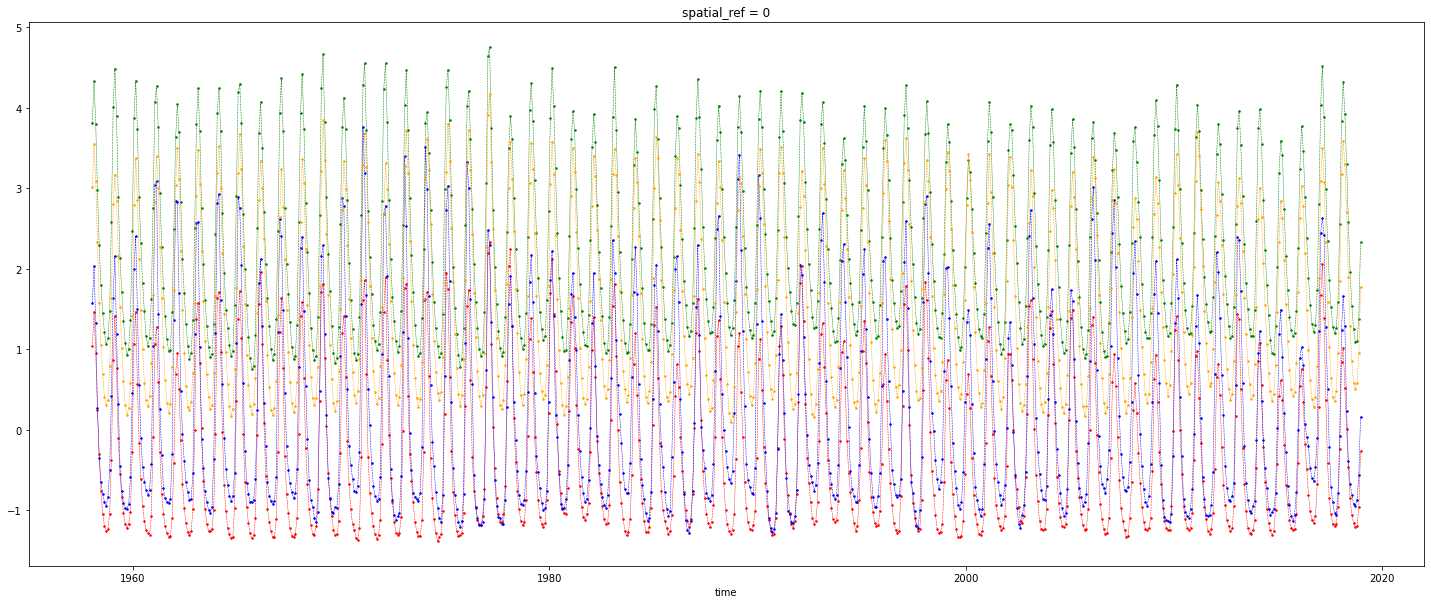

In [19]:
fig, ax = plt.subplots(figsize = (25, 10))
weightedIndian.plot(ax = ax, linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5, color = 'g')
weightedWP.plot(ax = ax, linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5, color = 'red')
weightedEP.plot(ax = ax, linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5, color = 'blue')
weightedAtlantic.plot(ax = ax, linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5, color = 'orange')

Text(0.5, 1.01, 'Atlantic')

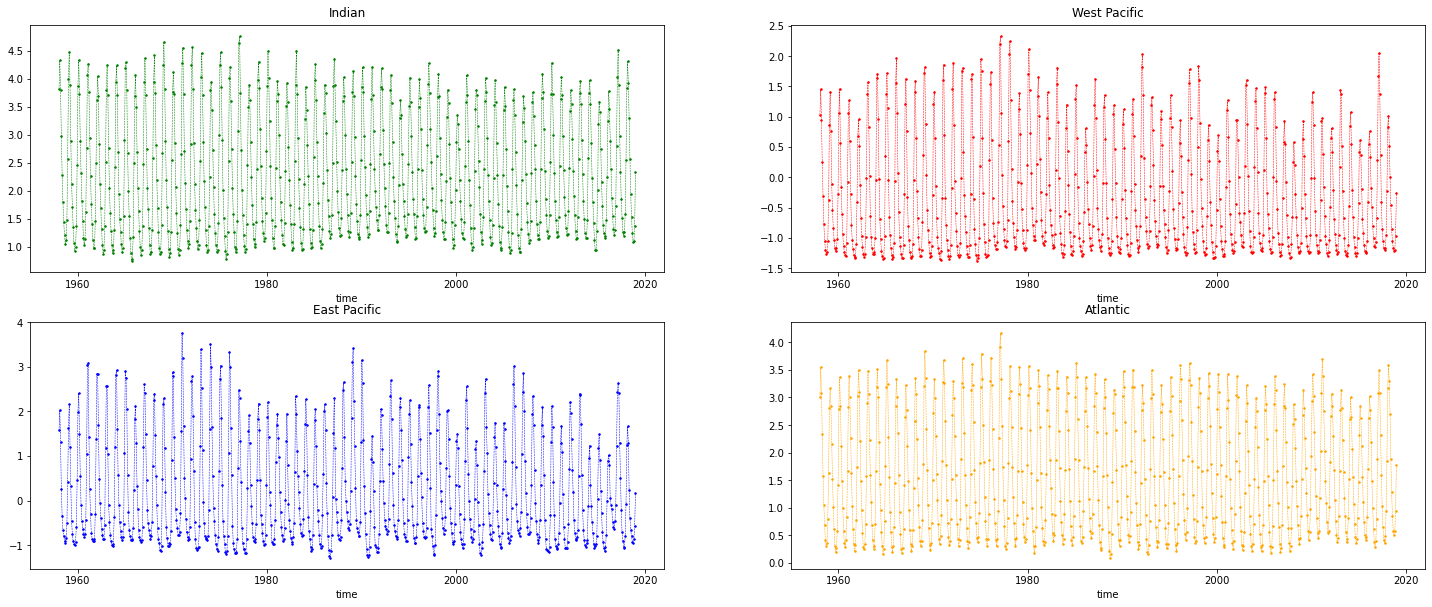

In [20]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize = (25, 10))
#Create a grid layout to place all subplots in one figure - 4x4 grid created to center bottom plot
gs = gridspec.GridSpec(nrows = 2, ncols = 2)

Ind = fig.add_subplot(gs[0, 0])
p_Ind = weightedIndian.plot(ax = Ind, linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5, color = 'g')
#Add subplot title
Ind.set_title('Indian', y = 1.01)

WP = fig.add_subplot(gs[0, 1])
p_WP = weightedWP.plot(ax = WP, linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5, color = 'red')
WP.set_title('West Pacific', y = 1.01)

EP = fig.add_subplot(gs[1, 0])
p_EP = weightedEP.plot(ax = EP, linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5, color = 'blue')
EP.set_title('East Pacific', y = 1.01)

Atl = fig.add_subplot(gs[1, 1])
p_Atl = weightedAtlantic.plot(ax = Atl, linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5, color = 'orange')
Atl.set_title('Atlantic', y = 1.01)

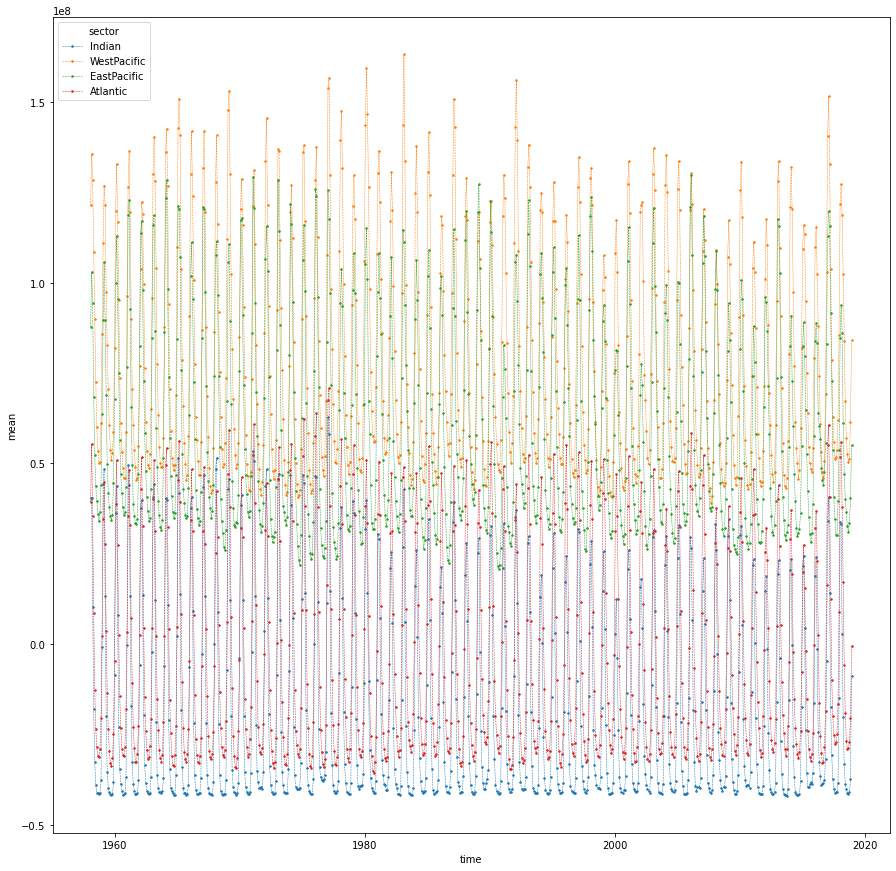

In [37]:
plt.subplots(figsize = (15, 15))
xr_stats['mean'].plot(hue = 'sector', linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5)

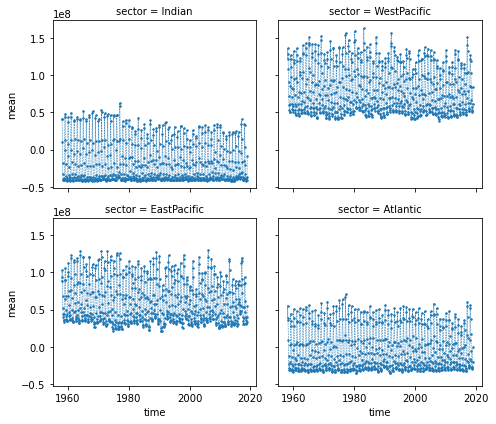

In [41]:
xr_stats['mean'].plot(col = 'sector', col_wrap = 2, linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5)